# Text Classification with Hugging Face
This notebook demonstrates the use of an open-source model from Hugging Face for the purpose of text classification.  

Specifically, we show the steps involved in this task, namely:
- Generate tokens (tokenization) and token embeddings (encoding) using the DistilBERT model's tokenizer and embedding layer.
- Train a model & predict with it.
- Save the model and push to Hugging Face.

<BR>
<div style="border:1px solid black; padding-top: 10px; padding-bottom: 10px; border-radius: 50px;">
    <center>
        <b>** Full disclosure **</b><BR>
        This notebook is based on chapter 2 of the following book<BR>
        <i>Natural Language Processing with Transformers [by Lewis Tunstall, Leandro von Werra & Thomas Wolf]</i>
    </center>
</div>
<BR>

## Datasets in Hugging Face
Let's start by seeing how many data sets exist in the hugging face library!

In [1]:
from huggingface_hub import list_datasets
all_datasets = list(list_datasets()) # Convert generator to list
print(f"There are {len(all_datasets)} datasets currently available on the Hub.")
print("\nThe first 10 are:", [x.id for x in all_datasets[:10]]) 

There are 409425 datasets currently available on the Hub.

The first 10 are: ['open-r1/Mixture-of-Thoughts', 'yandex/yambda', 'MiniMaxAI/SynLogic', 'cognitivecomputations/china-refusals', 'disco-eth/EuroSpeech', 'fka/awesome-chatgpt-prompts', 'yandex/alchemist', 'Tongyi-Zhiwen/DocQA-RL-1.6K', 'openbmb/Ultra-FineWeb', 'wikimedia/wikipedia']


---------------

## The Emotions Dataset
In this notebook, we shall demonstrate text classification using Hugging Face's `Transformers` library with the [Emotions data set](https://huggingface.co/datasets/emotion) by *dair-ai*.

### Get the dataset and have a look

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Observe the training set

In [3]:
# some stats and details
train_ds = emotions["train"]
print('_________________\n\ntype(train_ds)\n',        type(train_ds))         # data type of 'train_ds'
print('_________________\n\ntrain_ds\n',              train_ds)               # the emotions training set
print('_________________\n\nlen(train_ds)\n',         len(train_ds))          # size of training set (number of examples)
print('_________________\n\ntrain_ds.column_names\n', train_ds.column_names)  # features (just the column names)
print('_________________\n\ntrain_ds.features\n',     train_ds.features)      # features + their data types
print('_________________\n\ntrain_ds[:5]\n',          train_ds[:5])           # first 5 examples
print('_________________\n\ntrain_ds["text"][:5]\n',  train_ds["text"][:5])   # texts of first 5 examples
print('_________________')

_________________

type(train_ds)
 <class 'datasets.arrow_dataset.Dataset'>
_________________

train_ds
 Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
_________________

len(train_ds)
 16000
_________________

train_ds.column_names
 ['text', 'label']
_________________

train_ds.features
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
_________________

train_ds[:5]
 {'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
_________________

train_ds["text"][:5]
 ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awa

In [4]:
# convert to pandas data frame (from arrow dataset)
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
# add "label_name" column
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


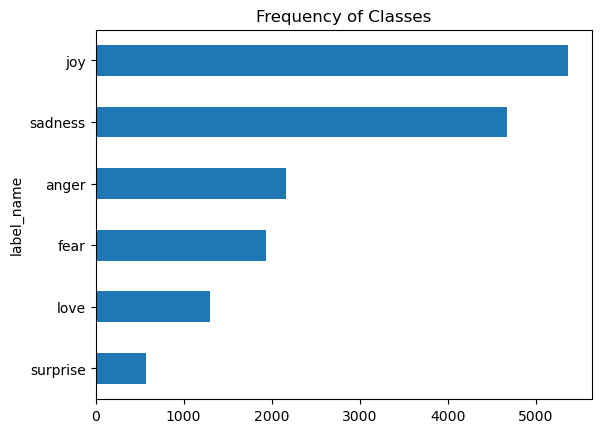

In [6]:
# observe class frequencies
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

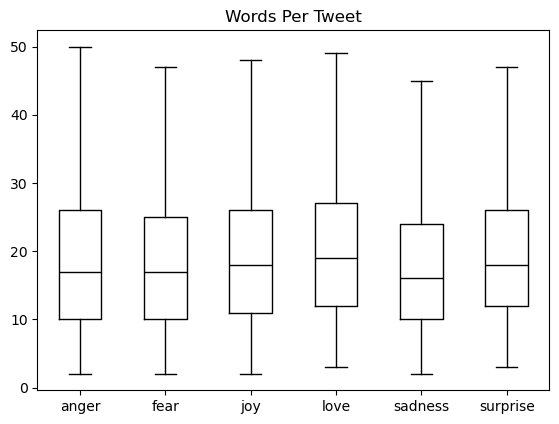

In [7]:
# stats: words per tweet
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [8]:
# we don't need data frame format anymore
emotions.reset_format()

------------------

## Text to Tokens
After having observed the data, it's time for the first step in text classification which is *tokenization* (i.e., the conversion of text into tokens).

*Tokens* are what later get converted into feature vectors called *token embeddings* that will be later fed into the classification model.

There is more than one way to tokenize text. We'll start with some simple tokenization methods, and then we'll go ahead and use a more sophisticated tokenizer that comes with the open-source model, [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased).

Below is an example that we will demonstrate the tokenization step on.

In [9]:
# example
text = "Tokenizing text is a core task of NLP."

### Character tokenization
The simplist way to tokenize text is to divide the text into single characters, and let each character be a token.

The code below first converts the text into character tokens, then we replace each of the tokens with a unique numerical representation; this process is called *numericalization*.

In [10]:
# tokens
tokenized_text = list(text)
print('\ntokens\n', tokenized_text)

# token-id pairs dictionary
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print('\ntoken2idx\n', token2idx)

# tokens to token ids
input_ids = [token2idx[token] for token in tokenized_text]
print('\ninput_ids\n', input_ids)


tokens
 ['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']

token2idx
 {' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}

input_ids
 [5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Next, we convert the numericalized tokens into token embeddings via one-hot encoding.

In [11]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [12]:
# as an example, show the first token, its id and its embedding
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization
Another way to tokenize text is to divide the text into words, and let each word be a token.

In [13]:
# tokens
tokenized_text = text.split()
print('\ntokens\n', tokenized_text)


tokens
 ['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


The above, if performed on the full emotions data set, would result in too many parameters! 

One solution is to consider the top 100K occurring words and label the rest as `UNK` (unknown).

Another solution is given in the next section below.

### Subword Tokenization
Subword tokenization is something that is halfway between character and word tokenization and is more online with what is typically done in practice.

A word may be divided into more than one token depending on whether it contains multiple building blocks; e.g., the word "tokenizing" may be considered as two tokens: "token" and "izing". See below for an example.

In the example below, we use the subword tokenizer provided by the open-source model, [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased).

In [14]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
# token ids
encoded_text = tokenizer(text)
print('\ntoken ids\n', encoded_text)

# tokens corresponding to token ids
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print('\ntokens\n', tokens)

# get original string back from token ids
print('\noriginal string\n', tokenizer.convert_tokens_to_string(tokens))


token ids
 {'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

tokens
 ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']

original string
 [CLS] tokenizing text is a core task of nlp. [SEP]


In [16]:
tokenizer.vocab_size

30522

In [17]:
tokenizer.model_max_length

512

In [18]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Emotions data set
Enough with the demonstrative examples already!

It's time to tokenize the Emotions data set.

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
# tokenize the first two examples, and make sure all is fine
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


What's worth noting above is that the first statement, being shorter, was padded with zeros so its length would match the longer second statement.

In [21]:
# curiousity: look at the special tokens of the DistilBERT tokenizer
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [22]:
# tokenize the emotions dataset (train, validation & test)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print('\nemotions\n', emotions)
print('\nemotions_encoded\n', emotions_encoded)

# "batched=True" ensures that the entire data (train, validation & test) are "together" when tokenized.
# This ensures that the padding phenomenon above is done properly so all the statements would have the same sequence length.


emotions
 DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

emotions_encoded
 DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [23]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


---------------

## Training a classifier
Now, let's train a classifier!

We will present two flavors here:
- Use the DistilBERT model for feature extraction by simply extracting the last hidden states without calculating any gradients, then use the extracted features to train a simple logistic regression model.
- Fine-tune the DistilBERT model (re-calculating the gradient) and predict with it.

In [24]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extract last hidden states without calculating gradient (EXAMPLE)
Let's try on an example first.

In [25]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [26]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():          # avoid calculating gradients
    outputs = model(**inputs)  # get last hidden state
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [27]:
outputs.last_hidden_state.size()  # shape = [batch_size, n_tokens, hidden_dim]

torch.Size([1, 6, 768])

In [28]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

### Extract last hidden states without calculating gradient (EMOTIONS dataset)
Now, let's do the same on the Emotions data set.

In [29]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [30]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [31]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [32]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Feature matrix

In [33]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualize data

In [34]:
from umap import umap_ as UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

C:\Users\ALiZaTo\anaconda3\envs\llms\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.295685,6.901504,0
1,-3.201706,5.962108,0
2,5.085232,3.447017,3
3,-2.403860,4.127000,2
4,-3.421966,4.105881,3


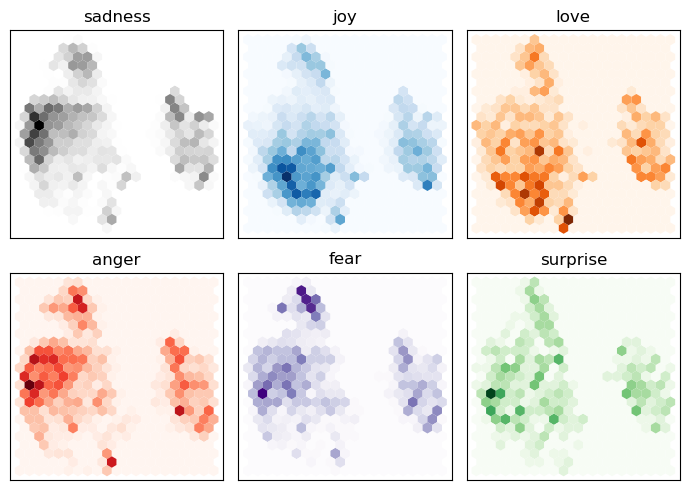

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Simple Classifier
Here, we train a a logistic regression model on the obtained hidden states, and compare it against a majority classifier to ensure everything is fine.

In [36]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

In [37]:
# majority classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

As expected, the logistic regression is doing significantly better than the majority classifier.

Below is a plot of a confusion matrix that shows how well the logistic regression model is predicting each of the labels. By looking at the off-diagonals, it seems *love* and *surprise* are frequently mistaken for *joy*, while *anger* is mistaken for *sadness*.

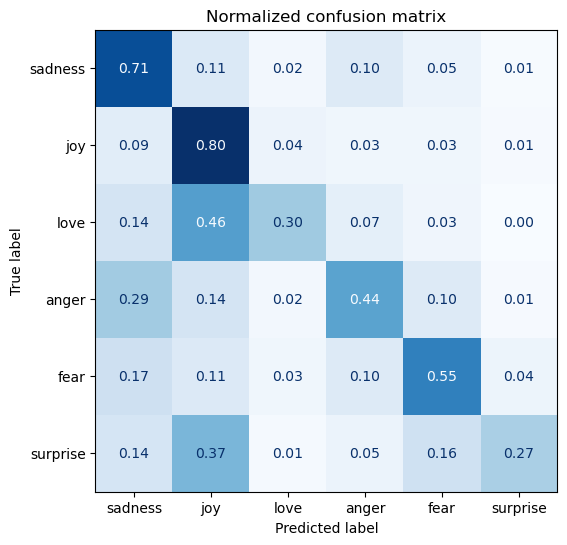

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tune transformers (i.e., re-calculate gradient)
The other option is to fine-tune the DistilBERT to our objective. There is better prediction performance to be had here, so let's go!

In [39]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [41]:
from huggingface_hub import notebook_login
notebook_login()

# # alternative that may be used from terminal
# huggingface-cli login

In [42]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

C:\Users\ALiZaTo\anaconda3\envs\llms\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

C:\Users\ALiZaTo\AppData\Local\Temp\ipykernel_16632\2172277720.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.810000,0.321527,0.906500,0.905837
2,0.250700,0.220148,0.927500,0.927402


TrainOutput(global_step=500, training_loss=0.530348503112793, metrics={'train_runtime': 130.9309, 'train_samples_per_second': 244.404, 'train_steps_per_second': 3.819, 'total_flos': 720342861696000.0, 'train_loss': 0.530348503112793, 'epoch': 2.0})

In [44]:
preds_output = trainer.predict(emotions_encoded["validation"])

# pred_labels = [x.argmax() for x in preds_output.predictions]
# df = pd.DataFrame({
#     'true_label': label_int2str(emotions["validation"]['label']), 
#     'pred_label': label_int2str(pred_labels)
# })

# print(df.value_counts('true_label'))
# print('')
# print(df.value_counts(['true_label', 'pred_label']).sort_index())

In [45]:
preds_output.metrics

{'test_loss': 0.22014759480953217,
 'test_accuracy': 0.9275,
 'test_f1': 0.9274022599563078,
 'test_runtime': 2.0402,
 'test_samples_per_second': 980.305,
 'test_steps_per_second': 15.685}

Accuracy improved to a whopping 92.7%! (up from logistic regression's accuracy of 63.5%)

In [46]:
y_preds = np.argmax(preds_output.predictions, axis=1)

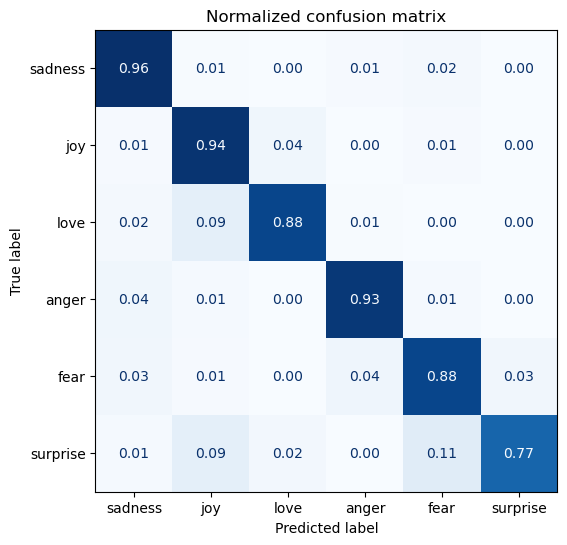

In [47]:
plot_confusion_matrix(y_preds, y_valid, labels)

From the image above, it seems that:
- *love*     gets mistaken for *joy* 9% of the time
- *surprise* gets mistaken for *joy* 9% of the time
- *surprise* gets mistaken for *fear* 11% of the time

### Error analysis
Here, we calculate the model losses on the examples of the validation set. Afterwards, we will sort by model loss to have a look at:
- the examples with the highest loss to see what kinds of examples the model tends to struggle with.
- the examples with the lowest loss to see what kinds of examples the model tends to have an easy time predicting correctly.

In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [49]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [50]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [51]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.590490
1950,i as representative of everything thats wrong ...,surprise,sadness,5.551438
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.382490
882,i feel badly about reneging on my commitment t...,love,sadness,5.373180
465,i would eventually go in to these stores but i...,joy,fear,5.312538
1274,i am going to several holiday parties and i ca...,joy,sadness,5.266641
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.154102
1801,i feel that he was being overshadowed by the s...,love,sadness,5.075813
765,i feel super awkward and out of place right now,joy,sadness,4.963080
1111,im lazy my characters fall into categories of ...,joy,fear,4.810503


In [52]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.016221
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.016230
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016397
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016412
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.016464
69,i have no extra money im worried all of the ti...,sadness,sadness,0.016528
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.016532
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.016536
189,i leave the meeting feeling more than a little...,sadness,sadness,0.016708
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016832


## Saving the model

Finally, we'll push the DistilBERT model (that we just fine-tuned on the Emotions data set) to HuggingFace. Having done that, we will get the uploaded model for one last test.

In [100]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/ALiZaTo/distilbert-base-uncased-finetuned-emotion/commit/c29e11f33600f0654ad8c9433c986b4f40750e53', commit_message='Training completed!', commit_description='', oid='c29e11f33600f0654ad8c9433c986b4f40750e53', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ALiZaTo/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='ALiZaTo/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [54]:
from transformers import pipeline

# Change `ALiZaTo` to your Hub username
model_id = "ALiZaTo/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [55]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

C:\Users\ALiZaTo\anaconda3\envs\llms\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


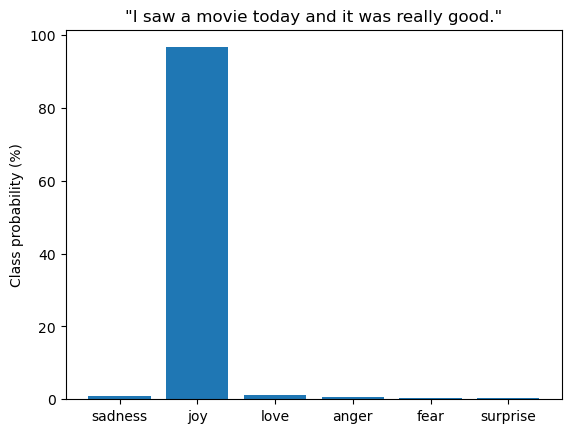

In [56]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()